In [4]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [6]:
def build_clustering_dataset_optimized(
    data,
    lepol_time,
    kiln_time,
    refroidisseur_time,
    type="mean",
    tol=0.01,
    include_std=False
):
    data = data.copy()
    data.index = pd.to_datetime(data.index)
    data = data[~data.index.duplicated(keep='first')]

    total_window = lepol_time + kiln_time + refroidisseur_time

    lepol_features = [
        'Température sur chambre chaude ',
        'Temperature Air Secondaire',
        'Oxygene Sortie Four',
        'NOx Sortie Four',
        'SO2 Sortie Four',
        'CO Sortie Four'
    ]

    kiln_features = [
        'Intensite Moteur Four',
        'Temperature Zone'
    ]

    input_features = [
        'Debit moyen entree farine Four  (CF)',
        'Debit Injection SQ7',
        'Debit moyen SOLVEN in Kiln'
    ]

    min_time = data.index.min()
    max_time = data.index.max()
    full_range = pd.date_range(start=min_time, end=max_time, freq='min')
    data_reindexed = data.reindex(full_range)

    valid_mask = data_reindexed.index.isin(data.index)

    quality_arr = data_reindexed['Mesure traitee CaOl Alcatron'].values
    input_arrays = {col: data_reindexed[col].values for col in input_features}
    lepol_arrays = {col: data_reindexed[col].values for col in lepol_features}
    kiln_arrays = {col: data_reindexed[col].values for col in kiln_features}

    max_start_idx = len(data_reindexed) - total_window - 1
    if max_start_idx < 0:
        return pd.DataFrame()

    valid_starts = []
    for i in range(max_start_idx + 1):
        lepol_end = i + lepol_time
        kiln_end = lepol_end + kiln_time
        refroid_idx = i + total_window
        if (refroid_idx < len(valid_mask) and
            valid_mask[i:lepol_end + 1].all() and
            valid_mask[lepol_end:kiln_end + 1].all() and
            valid_mask[refroid_idx]):
            valid_starts.append(i)

    if not valid_starts:
        return pd.DataFrame()

    valid_starts = np.array(valid_starts)
    n_windows = len(valid_starts)
    end_indices = valid_starts + total_window
    end_times = full_range[end_indices]

    print(f"Building {n_windows} valid windows...")

    result_dict = {
        'Time': end_times,
        'Mesure traitee CaOl Alcatron': quality_arr[end_indices]
    }

    # input features at start
    for col in input_features:
        result_dict[col] = input_arrays[col][valid_starts]

    # lepol / kiln features
    if type in ["mean", "mean_std"]:
        for col in lepol_features:
            arr = lepol_arrays[col]
            means = np.empty(n_windows, dtype=float)
            stds = np.empty(n_windows, dtype=float) if include_std else None
            for j, start_idx in enumerate(valid_starts):
                segment = arr[start_idx:start_idx + lepol_time + 1]
                means[j] = np.nanmean(segment)
                if include_std:
                    stds[j] = np.nanstd(segment)
            result_dict[f"{col}_lepol_mean"] = means
            if include_std:
                result_dict[f"{col}_lepol_std"] = stds

        for col in kiln_features:
            arr = kiln_arrays[col]
            means = np.empty(n_windows, dtype=float)
            stds = np.empty(n_windows, dtype=float) if include_std else None
            for j, start_idx in enumerate(valid_starts):
                kstart = start_idx + lepol_time
                segment = arr[kstart:kstart + kiln_time + 1]
                means[j] = np.nanmean(segment)
                if include_std:
                    stds[j] = np.nanstd(segment)
            result_dict[f"{col}_kiln_mean"] = means
            if include_std:
                result_dict[f"{col}_kiln_std"] = stds

    elif type == "segment":
        # Lepol features
        for col in lepol_features:
            arr = lepol_arrays[col]
            for i in range(lepol_time + 1):
                result_dict[f"{col}_lepol_t{i}"] = [arr[start_idx + i] for start_idx in valid_starts]
    
        # Kiln features
        for col in kiln_features:
            arr = kiln_arrays[col]
            for i in range(kiln_time + 1):
                result_dict[f"{col}_kiln_t{i}"] = [arr[start_idx + lepol_time + i] for start_idx in valid_starts]

    clustering_data = pd.DataFrame(result_dict)
    clustering_data.set_index("Time", inplace=True)

    labels_arr = np.full(n_windows, -1, dtype=int)
    curr_idx = end_indices
    prev_idx = curr_idx - 1
    valid_prev = (prev_idx >= 0) & valid_mask[prev_idx]

    if valid_prev.any():
        curr_vals = quality_arr[curr_idx[valid_prev]]
        prev_vals = quality_arr[prev_idx[valid_prev]]
        ok_vals = (~np.isnan(curr_vals)) & (~np.isnan(prev_vals)) & (curr_vals != 0) & (prev_vals != 0)
        label_mask = ok_vals & (np.abs(curr_vals - prev_vals) > tol)
        labels = np.where(curr_vals[label_mask] <= 3.5, 1, 0)
        positions = np.flatnonzero(valid_prev)
        label_positions = positions[label_mask]
        labels_arr[label_positions] = labels

    clustering_data['Labels'] = labels_arr
    return clustering_data


In [5]:
class SimplifiedSemiSupervisedGMM:
    
    """Simplified GMM with 'super-class' prior
    
    This class allows to estimate the parameters of a Gaussian mixture for wich the data has prior labels
    
    Parameters
    
    --------------
    n_components: int default = 1
        The number of mixture components
    
    conv_tresh: float default = 1e-3
        The convergence threshold for which the EM algorithm is stopped
        
    max_iter: int default = 100
        The number of iteration of the EM algorithm if the threshold is not reached
        
    Attributes:
    --------------
    
    weights_: array-like of shape (n_components,)
        The weight of each mixture component
        
    means_ = array-like of shape (n_components, n_features)
        The mean of eachg mixture component
        
    covariance_ = array-like of shape (n_components, n_features, n_features)
    
    class_cluster_probs = array-like of shape (n_classes, n_components)

    """
        
    def __init__(self, n_components=1, n_classes=2, max_iter=50, conv_thresh=1e-3):
        self.K = n_components
        self.M = n_classes
        self.max_iter = max_iter
        self.conv_thresh = conv_thresh

        self.means_ = None            # shape (K, D)
        self.covariances_ = None      # shape (K, D, D)
        self.weights_ = None          # shape (K,)
        self.class_cluster_probs_ = None  # r_{i,k}, shape (M, K)
        self.log_likelihoods_ = []    # list of floats    
        
    def initialize_parameters(self, X, y_labeled):
        """
        Improved initialization: use KMeans per class to initialize means, covariances, weights, and class-cluster probs.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        y_labeled : array-like of shape (n_samples,)
        """
        n_samples, n_features = X.shape
        self.means_ = []
        self.covariances_ = []
        self.weights_ = np.zeros(self.K)
        self.class_cluster_probs_ = np.zeros((self.M, self.K))

        clusters_per_class = self._split_clusters_among_classes(self.K, self.M)
        cluster_index = 0

        for i in range(self.M):
            class_data = X[y_labeled == i]
            k_i = clusters_per_class[i]

            if k_i == 0:
                continue

            kmeans = KMeans(n_clusters=k_i, random_state=42, n_init=10)
            kmeans.fit(class_data)

            for j in range(k_i):
                cluster_data = class_data[kmeans.labels_ == j]
                mu = kmeans.cluster_centers_[j]
                self.means_.append(mu)

                if len(cluster_data) > 1:
                    cov = np.cov(cluster_data, rowvar=False)
                else:
                    cov = np.eye(n_features)
                cov += 1e-6 * np.eye(n_features)

                self.covariances_.append(cov)

                self.weights_[cluster_index] = len(cluster_data) / n_samples
                self.class_cluster_probs_[i, cluster_index] = 1.0  # hard assignment

                cluster_index += 1

        self.means_ = np.array(self.means_)
        self.covariances_ = np.array(self.covariances_)
        self.weights_ = self.weights_ / np.sum(self.weights_)  # Normalize
        self.class_cluster_probs_ = self.class_cluster_probs_ / np.clip(self.class_cluster_probs_.sum(axis=0, keepdims=True), 1e-12, None)
        
    def _split_clusters_among_classes(self, total_k, num_classes):
        """
        Split total clusters across classes as evenly as possible.
        """
        base = total_k // num_classes
        remainder = total_k % num_classes
        return [base + 1 if i < remainder else base for i in range(num_classes)]

    def e_step(self, X_labeled, y_labeld):
        """
        E-step: compute responsibilities γ_{i,k}(x) for each labeled point.

        Parameters
        ----------
        X_labeled : array-like of shape (n_samples, n_features)
        y_labeled : array-like of shape (n_samples,), class labels (in 0,...,M-1)

        Returns
        -------
        gamma : array of shape (n_samples, K)
            Posterior probabilities of each cluster for each sample
        """
        
        n_sample, n_features = X_labeled.shape
        gamma = np.zeros((n_sample, self.K))
        
        for n in range(n_sample):
            x=X_labeled[n]
            c=y_labeld[n]
            numerators = np.zeros(self.K)
            
            for k in range(self.K):
                p_x_given_k = multivariate_normal.pdf(x, mean=self.means_[k], cov=self.covariances_[k])
                numerators[k] = self.class_cluster_probs_[c,k] * self.weights_[k] * p_x_given_k
                
            determinator = np.sum(numerators) + 1e-12
            gamma[n, :] = numerators / determinator
        
        return gamma
        
    def m_step(self, X_labeled, y_labeled, gamma):
        """
        M-step: update means, covariances, weights, and class-cluster probabilities.

        Parameters
        ----------
        X_labeled : array of shape (n_samples, n_features)
        y_labeled : array of shape (n_samples,)
        gamma : array of shape (n_samples, K)
            Responsibilities from E-step
        """
        n_samples, n_features = X_labeled.shape
        N_k = np.sum(gamma, axis=0)  
        
        self.means_ = np.zeros((self.K, n_features))
        for k in range(self.K):
            self.means_[k] = np.sum(gamma[:, k, np.newaxis] * X_labeled, axis=0) / (N_k[k] + 1e-12)


        self.covariances_ = np.zeros((self.K, n_features, n_features))
        for k in range(self.K):
            diff = X_labeled - self.means_[k]
            weighted_outer = np.einsum('ni,nj->nij', diff, diff) 
            self.covariances_[k] = np.tensordot(gamma[:, k], weighted_outer, axes=([0], [0])) / (N_k[k] + 1e-12)


        self.weights_ = N_k / np.sum(N_k)


        self.class_cluster_probs_ = np.zeros((self.M, self.K))
        for i in range(self.M):
            class_mask = (y_labeled == i)
            for k in range(self.K):
                self.class_cluster_probs_[i, k] = np.sum(gamma[class_mask, k])
        self.class_cluster_probs_ /= (N_k[np.newaxis, :] + 1e-12)

    def fit(self, X_labeled, y_labeled):
        """
        Fit the model using the EM algorithm on labeled data.

        Parameters
        ----------
        X_labeled : array-like of shape (n_samples, n_features)
        y_labeled : array-like of shape (n_samples,), class labels
        """
        self.initialize_parameters(X_labeled, y_labeled)
        prev_likelihood = None

        for iteration in range(self.max_iter):
            gamma = self.e_step(X_labeled, y_labeled)

            self.m_step(X_labeled, y_labeled, gamma)

            log_likelihood = 0.0
            for i in range(self.M):
                class_mask = (y_labeled == i)
                X_class = X_labeled[class_mask]
                
                for x in X_class:
                    likelihood = 0.0
                    for k in range(self.K):
                        p = self.class_cluster_probs_[i, k] * self.weights_[k] * \
                            multivariate_normal.pdf(x, mean=self.means_[k], cov=self.covariances_[k])
                        likelihood += p
                    log_likelihood += np.log(likelihood + 1e-12)

            self.log_likelihoods_.append(log_likelihood)

            if prev_likelihood is not None and abs(log_likelihood - prev_likelihood) < self.conv_thresh:
                print(f"Converged at iteration {iteration}")
                break

            prev_likelihood = log_likelihood
            
    def predict_clusters(self, X):
        """
        Predict cluster responsibilities for unlabeled data
        """
        n_samples = X.shape[0]
        gamma = np.zeros((n_samples, self.K))
        
        for n in range(n_samples):
            x = X[n]
            numerators = np.zeros(self.K)
            for k in range(self.K):
                p_x_given_k = multivariate_normal.pdf(x, mean=self.means_[k], cov=self.covariances_[k])
                numerators[k] = self.weights_[k] * p_x_given_k
            gamma[n] = numerators / (np.sum(numerators) + 1e-12)

        return np.argmax(gamma, axis=1)
     
    def plot_log_likelihood(self):
        """Plot log-likelihood over iterations."""
        if not self.log_likelihoods_:
            print("No log-likelihood values to plot.")
            return
        plt.figure(figsize=(8, 4))
        plt.plot(self.log_likelihoods_, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.title("Log-Likelihood Over EM Iterations")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_tsne_clusters(self, X_labeled, y_labeled):
        """
        t-SNE projection colored by predicted cluster, with outline showing true class.
        """
        cluster_preds = self.predict_clusters(X_labeled)

        tsne = TSNE(n_components=2, random_state=42, init='pca')
        X_2d = tsne.fit_transform(X_labeled)

        plt.figure(figsize=(8, 6))
        for i in range(len(X_labeled)):
            plt.scatter(X_2d[i, 0], X_2d[i, 1],
                color=plt.cm.viridis(cluster_preds[i] / self.K),
                edgecolors='k' if y_labeled[i] == 0 else 'r',
                linewidths=0.8, s=40)

        plt.title("t-SNE: Clusters (color) and Classes (outline)")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_pca_gaussians(self, X_labeled, y_labeled):
        """
        PCA projection colored by true class, with Gaussian ellipses from each cluster.
        """
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X_labeled)

        means_2d = pca.transform(self.means_)
        covs_2d = [pca.components_ @ self.covariances_[k] @ pca.components_.T for k in range(self.K)]

        plt.figure(figsize=(8, 6))
        for class_id in range(self.M):
            mask = y_labeled == class_id
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1],
                        label=f"Class {class_id}", alpha=0.6, s=40)

        for k in range(self.K):
            eigvals, eigvecs = np.linalg.eigh(covs_2d[k])
            order = eigvals.argsort()[::-1]
            eigvals, eigvecs = eigvals[order], eigvecs[:, order]
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)  

            ellipse = Ellipse(xy=means_2d[k],
                            width=width, height=height,
                            angle=angle, edgecolor='black',
                            facecolor='none', lw=2, linestyle='--')
            plt.gca().add_patch(ellipse)

        plt.title("PCA: Classes (color) and Gaussians (ellipses)")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_feature_histograms_with_gaussians(self, X):
        """
        Plot histogram of each feature and overlay the 1D marginal Gaussians from each cluster.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The dataset used for comparison.
        """
        n_features = X.shape[1]
        x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)

        fig, axes = plt.subplots(nrows=n_features, ncols=1, figsize=(8, 2.5 * n_features))
        if n_features == 1:
            axes = [axes]

        x_grid = [np.linspace(x_min[j] - 1, x_max[j] + 1, 300) for j in range(n_features)]

        for j, ax in enumerate(axes):
            ax.hist(X[:, j], bins=30, density=True, alpha=0.5, color='gray', label="Data")

            for k in range(self.K):
                mu = self.means_[k, j]
                sigma = np.sqrt(self.covariances_[k, j, j])  
                weight = self.weights_[k]

                y = weight * norm.pdf(x_grid[j], mu, sigma)
                ax.plot(x_grid[j], y)

            ax.set_title(f"Feature {j}")
            ax.legend()

        plt.tight_layout()
        plt.show()

class UnsimplifiedSemiSupervisedGMM:
    def __init__(self, n_components=1, n_classes=2, max_iter=100, conv_thresh=1e-3):
        self.K = n_components
        self.M = n_classes
        self.max_iter = max_iter
        self.conv_thresh = conv_thresh

        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.log_likelihoods_ = []
        self.r_x_ = None  # shape (n_samples, M, K)

    def initialize_parameters(self, X, y_labeled, method='kmeans'):
        """
        Initialize means, covariances, weights, and r_x using KMeans or GMM per class.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
        y_labeled : ndarray of shape (n_samples,)
        method : str, 'kmeans' or 'gmm'
            Method to initialize clusters per class.
        """
        n_samples, n_features = X.shape
        self.means_ = []
        self.covariances_ = []
        self.weights_ = np.zeros(self.K)
        self.r_x_ = np.zeros((n_samples, self.M, self.K))

        clusters_per_class = self._split_clusters_among_classes(self.K, self.M)
        cluster_index = 0

        for i in range(self.M):
            class_data = X[y_labeled == i]
            k_i = clusters_per_class[i]
            if k_i == 0:
                continue

            cluster_sample_indices = np.where(y_labeled == i)[0]

            if method == 'gmm':
                gmm = GaussianMixture(n_components=k_i, covariance_type='full', random_state=42, max_iter=100, n_init=1)
                gmm.fit(class_data)
                responsibilities = gmm.predict_proba(class_data)

                for j in range(k_i):
                    mu = gmm.means_[j]
                    cov = gmm.covariances_[j]
                    if cov.ndim == 1:
                        cov = np.diag(cov)
                    elif cov.ndim == 0:
                        cov = np.eye(n_features) * cov

                    self.means_.append(mu)
                    self.covariances_.append(cov)

                    for idx_in_class, n in enumerate(cluster_sample_indices):
                        self.r_x_[n, i, cluster_index] = responsibilities[idx_in_class, j]

                    self.weights_[cluster_index] = np.sum(responsibilities[:, j]) / n_samples
                    cluster_index += 1

            elif method == 'kmeans':
                kmeans = KMeans(n_clusters=k_i, n_init=10, random_state=42)
                labels = kmeans.fit_predict(class_data)

                for j in range(k_i):
                    cluster_data = class_data[labels == j]
                    mu = kmeans.cluster_centers_[j]
                    self.means_.append(mu)

                    cov = np.cov(cluster_data, rowvar=False) if len(cluster_data) > 1 else np.eye(n_features)
                    cov += 1e-6 * np.eye(n_features)
                    self.covariances_.append(cov)

                    for idx_in_class, n in enumerate(cluster_sample_indices):
                        if labels[idx_in_class] == j:
                            self.r_x_[n, i, cluster_index] = 1.0

                    self.weights_[cluster_index] = len(cluster_data) / n_samples
                    cluster_index += 1

            else:
                raise ValueError(f"Unknown initialization method: {method}")

        self.means_ = np.array(self.means_)
        self.covariances_ = np.array(self.covariances_)
        self.weights_ /= np.sum(self.weights_)

        # Normalize r_x
        norm = np.sum(self.r_x_, axis=1, keepdims=True) + 1e-12
        self.r_x_ /= norm
            
    def _split_clusters_among_classes(self, total_k, num_classes):
        """
        Evenly assign clusters to each class.
        """
        base = total_k // num_classes
        remainder = total_k % num_classes
        return [base + 1 if i < remainder else base for i in range(num_classes)]

    def e_step(self, X_labeled, y_labeled):
        n_samples = X_labeled.shape[0]
        gamma = np.zeros((n_samples, self.K))
        for n in range(n_samples):
            x = X_labeled[n]
            i = y_labeled[n]
            numerators = np.zeros(self.K)
            for k in range(self.K):
                p_x_given_k = multivariate_normal.pdf(x, mean=self.means_[k], cov=self.covariances_[k])
                numerators[k] = self.r_x_[n, i, k] * self.weights_[k] * p_x_given_k
            gamma[n] = numerators / (np.sum(numerators) + 1e-12)
        return gamma

    def update_r_x(self, gamma, y_labeled):
        n_samples = gamma.shape[0]
        self.r_x_ = np.zeros((n_samples, self.M, self.K))  # Reset r_x

        for n in range(n_samples):
            c = y_labeled[n]
            for k in range(self.K):
                self.r_x_[n, c, k] = gamma[n, k]  

            total = np.sum(self.r_x_[n, :, :], axis=0, keepdims=True) + 1e-12
            self.r_x_[n, :, :] /= total  # shape: (1, K), broadcasted over M

    def m_step(self, X_labeled, gamma):
        n_samples, n_features = X_labeled.shape
        N_k = np.sum(gamma, axis=0)
        self.means_ = np.zeros((self.K, n_features))
        self.covariances_ = np.zeros((self.K, n_features, n_features))

        for k in range(self.K):
            self.means_[k] = np.sum(gamma[:, k, np.newaxis] * X_labeled, axis=0) / (N_k[k] + 1e-12)
            diff = X_labeled - self.means_[k]
            weighted_outer = np.einsum('ni,nj->nij', diff, diff)
            cov_k = np.tensordot(gamma[:, k], weighted_outer, axes=([0], [0])) / (N_k[k] + 1e-12)
    
            cov_k += 1e-6 * np.eye(n_features) 
            self.covariances_[k] = cov_k

        self.weights_ = N_k / np.sum(N_k)

    def compute_log_likelihood(self, X_labeled, y_labeled):
        n_samples = X_labeled.shape[0]
        log_likelihood = 0.0
        for n in range(n_samples):
            x = X_labeled[n]
            i = y_labeled[n]
            total = 0.0
            for k in range(self.K):
                p = self.r_x_[n, i, k] * self.weights_[k] * multivariate_normal.pdf(x, mean=self.means_[k], cov=self.covariances_[k])
                total += p
            log_likelihood += np.log(total + 1e-12)
        return log_likelihood

    def fit(self, X_labeled, y_labeled, init_method='gmm'):
        self.initialize_parameters(X_labeled, y_labeled, method=init_method)
        prev_likelihood = None

        for iteration in range(self.max_iter):
            gamma = self.e_step(X_labeled, y_labeled)
            self.update_r_x(gamma, y_labeled)
            self.m_step(X_labeled, gamma)
            log_likelihood = self.compute_log_likelihood(X_labeled, y_labeled)
            self.log_likelihoods_.append(log_likelihood)

            if prev_likelihood is not None and abs(log_likelihood - prev_likelihood) < self.conv_thresh:
                print(f"Converged at iteration {iteration}")
                break

            prev_likelihood = log_likelihood

    def predict_clusters(self, X):
        """
        Predict cluster responsibilities for unlabeled data
        """
        n_samples = X.shape[0]
        gamma = np.zeros((n_samples, self.K))
        
        for n in range(n_samples):
            x = X[n]
            numerators = np.zeros(self.K)
            for k in range(self.K):
                p_x_given_k = multivariate_normal.pdf(x, mean=self.means_[k], cov=self.covariances_[k])
                numerators[k] = self.weights_[k] * p_x_given_k
            gamma[n] = numerators / (np.sum(numerators) + 1e-12)

        cluster_preds = np.argmax(gamma, axis=1)
        cluster_probs = np.max(gamma, axis=1)  

        return cluster_preds, cluster_probs, gamma
    
    def predict_with_threshold(self, X, thresholds):
        cluster_preds, cluster_probs, _ = self.predict_clusters(X)

        for i in range(len(cluster_preds)):
            cluster = cluster_preds[i]
            if cluster_probs[i] < thresholds.get(cluster, 0.5):  
                cluster_preds[i] = -1  

        return cluster_preds
    
    def predict_with_cross_cluster_proba(self, gamma, true_labels, threshold=0.5):
        
        true_labels = np.array(true_labels).ravel()
        n_samples, n_clusters = gamma.shape
        n_classes = np.max(true_labels) + 1  # assumes labels are [0, ..., n-1]

        # Step 1: Assign each cluster to a class
        cluster_to_class = {}

        for k in range(n_clusters):
            high_resp_indices = gamma[:, k] > threshold
            if np.sum(high_resp_indices) == 0:
                cluster_to_class[k] = 0  # fallback to class 0
            else:
                majority_class = np.bincount(true_labels[high_resp_indices], minlength=n_classes).argmax()
                cluster_to_class[k] = majority_class

        # Step 2: Compute class probabilities for each sample
        class_probs = np.zeros((n_samples, n_classes))

        for k in range(n_clusters):
            assigned_class = cluster_to_class[k]
            class_probs[:, assigned_class] += gamma[:, k]

        # Step 3: Assign hard labels
        predicted_labels = np.argmax(class_probs, axis=1)
        
        cm = confusion_matrix(true_labels, predicted_labels)
        acc = accuracy_score(true_labels, predicted_labels)

        # Use weighted average for multi-class (default handles binary too)
        prec = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        rec = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

        print("Confusion Matrix:")
        print(cm)
        print(f"\nAccuracy:  {acc:.3f}")
        print(f"Precision: {prec:.3f}")
        print(f"Recall:    {rec:.3f}")
        print(f"F1 Score:  {f1:.3f}")

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

        return predicted_labels, class_probs   
     
    def predict_with_cross_cluster_proba_with_threshold(self, predicted_labels, class_probs, thresholds):
        filtered_preds = []

        for i, label in enumerate(predicted_labels):
            prob = class_probs[i][label]
            threshold = thresholds.get(label, 0.5)  # default to 0.5 if not specified

            if prob >= threshold:
                filtered_preds.append(label)
            else:
                filtered_preds.append(-1)

        return np.array(filtered_preds)
        
        
    def plot_log_likelihood(self):
        if not self.log_likelihoods_:
            print("No log-likelihood values to plot.")
            return
        plt.figure(figsize=(8, 4))
        plt.plot(self.log_likelihoods_, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Negative Log-Likelihood")
        plt.title("Log-Likelihood Over EM Iterations")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_tsne_clusters(self, X_labeled, y_labeled):
        cluster_preds, _, _ = self.predict_clusters(X_labeled)
        tsne = TSNE(n_components=2, random_state=42, init='pca')
        X_2d = tsne.fit_transform(X_labeled)
        plt.figure(figsize=(8, 6))
        for i in range(len(X_labeled)):
            plt.scatter(X_2d[i, 0], X_2d[i, 1],
                        color=plt.cm.viridis(cluster_preds[i] / self.K),
                        edgecolors='k' if y_labeled[i] == 0 else 'r',
                        linewidths=0.8, s=40)
        plt.title("t-SNE: Clusters (color) and Classes (outline)")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_pca_gaussians(self, X_labeled, y_labeled):
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X_labeled)
        means_2d = pca.transform(self.means_)
        covs_2d = [pca.components_ @ self.covariances_[k] @ pca.components_.T for k in range(self.K)]
        plt.figure(figsize=(8, 6))
        for class_id in range(self.M):
            mask = y_labeled == class_id
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=f"Class {class_id}", alpha=0.6, s=40)
        for k in range(self.K):
            eigvals, eigvecs = np.linalg.eigh(covs_2d[k])
            order = eigvals.argsort()[::-1]
            eigvals, eigvecs = eigvals[order], eigvecs[:, order]
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)
            ellipse = Ellipse(xy=means_2d[k], width=width, height=height,
                              angle=angle, edgecolor='black', facecolor='none',
                              lw=2, linestyle='--')
            plt.gca().add_patch(ellipse)
        plt.title("PCA: Classes (color) and Gaussians (ellipses)")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_feature_histograms_with_gaussians(self, X):
        n_features = X.shape[1]
        x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
        fig, axes = plt.subplots(nrows=n_features, ncols=1, figsize=(8, 2.5 * n_features))
        if n_features == 1:
            axes = [axes]
        x_grid = [np.linspace(x_min[j] - 1, x_max[j] + 1, 300) for j in range(n_features)]
        for j, ax in enumerate(axes):
            ax.hist(X[:, j], bins=30, density=True, alpha=0.5, color='gray', label="Data")
            for k in range(self.K):
                mu = self.means_[k, j]
                sigma = np.sqrt(self.covariances_[k, j, j])
                weight = self.weights_[k]
                y = weight * norm.pdf(x_grid[j], mu, sigma)
                ax.plot(x_grid[j], y)
            ax.set_title(f"Feature {j}")
            ax.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
def evaluate_cluster_labels(cluster_labels, original_labels):
    df = pd.DataFrame({
        'Cluster': cluster_labels,
        'TrueLabel': original_labels
    })

    overall_positive_percentage = (df['TrueLabel'] == 1).mean()
    overall_negative_percentage = (df['TrueLabel'] == 0).mean()

    print(f'Overall positive percentage: {overall_positive_percentage:.2%}')
    print(f'Overall negative percentage: {overall_negative_percentage:.2%}')
    print("\nCluster composition relative to global proportions:\n")

    metrics = []
    for cluster_id in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster_id]
        total_in_cluster = len(cluster_data)
        count_0 = (cluster_data['TrueLabel'] == 0).sum()
        count_1 = (cluster_data['TrueLabel'] == 1).sum()

        ratio_0 = (count_0 / total_in_cluster) / overall_negative_percentage
        ratio_1 = (count_1 / total_in_cluster) / overall_positive_percentage

        metric = abs(ratio_0 - ratio_1)/2
        metrics.append(metric)
        
        print(f'Cluster {cluster_id}:')
        print(f'  Size: {total_in_cluster}')
        print(f'  Label 0 (relative ratio): {ratio_0:.2f}')
        print(f'  Label 1 (relative ratio): {ratio_1:.2f}')
        print(f'  Evaluation metric: {metric:.2f}')

        print('-' * 40)

    print(f"Cross cluster evaluation metric (between 0 and 1, the higher the better): {np.mean(metrics):.2f}")

In [7]:
csv_path = "/Users/foucauld/Desktop/stage_centre_Borelli/Clean_code/Clustering/clean_raw_data.csv"

data = pd.read_csv(csv_path, sep=',')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
print(len(data))
# Keep the first row for each timestamp
data = data[~data.index.duplicated(keep='first')]
print(len(data))

96358
94919


In [8]:
clustering_data_optimal_time_mean = build_clustering_dataset_optimized(data, lepol_time=20, kiln_time=30, refroidisseur_time=40, type="mean",tol=0.01, include_std=False)

Building 94649 valid windows...


In [9]:
count_0_mean = (clustering_data_optimal_time_mean['Labels'] == 0).sum()
count_1_mean = (clustering_data_optimal_time_mean['Labels'] == 1).sum()
if count_0_mean == 0 or count_1_mean == 0:
    print("Skipping: one class has 0 samples")

class_0_mean = clustering_data_optimal_time_mean[clustering_data_optimal_time_mean['Labels'] == 0]
class_1_mean = clustering_data_optimal_time_mean[clustering_data_optimal_time_mean['Labels'] == 1]
class_1_downsampled_mean = class_1_mean.sample(count_0_mean, random_state=42)
balanced_data_mean = pd.concat([class_0_mean, class_1_downsampled_mean])

X_mean = balanced_data_mean.drop(columns=['Labels', 'Mesure traitee CaOl Alcatron'])
y_mean = balanced_data_mean['Labels']

scaler = StandardScaler()
X_scaled_mean = scaler.fit_transform(X_mean)

X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(
    X_scaled_mean, y_mean, test_size=0.2, random_state=42, stratify=y_mean, shuffle=True
)

/var/folders/9g/tyrn_v0s4hl73n17fjvdy4kw0000gn/T/ipykernel_80697/2378893636.py:444: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i = y_labeled[n]
/var/folders/9g/tyrn_v0s4hl73n17fjvdy4kw0000gn/T/ipykernel_80697/2378893636.py:457: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = y_labeled[n]
/var/folders/9g/tyrn_v0s4hl73n17fjvdy4kw0000gn/T/ipykernel_80697/2378893636.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i = y_labele

Converged at iteration 31


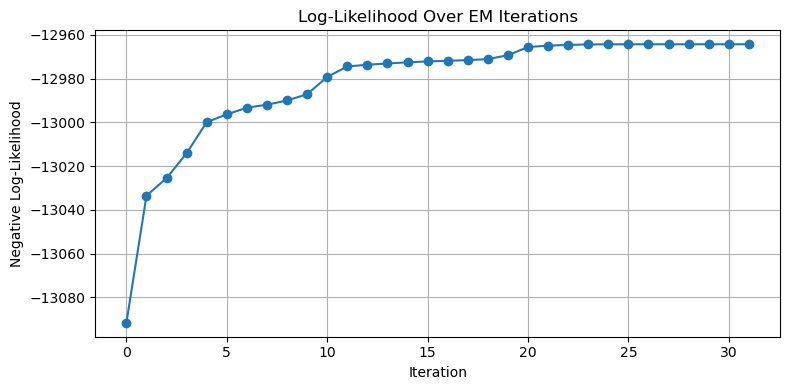

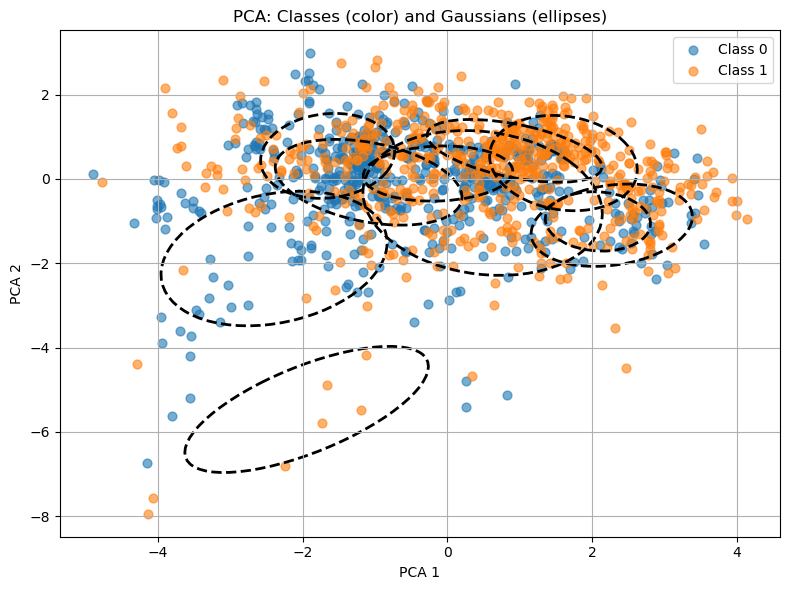

/var/folders/9g/tyrn_v0s4hl73n17fjvdy4kw0000gn/T/ipykernel_80697/2378893636.py:630: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edgecolors='k' if y_labeled[i] == 0 else 'r',


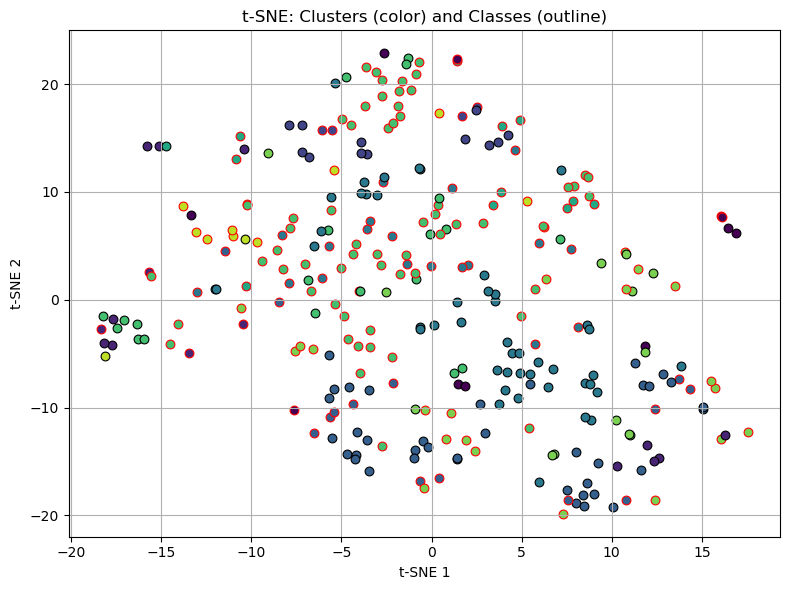

Evaluation for Unsimplified Semi-Supervised GMM
Overall positive percentage: 49.83%
Overall negative percentage: 50.17%

Cluster composition relative to global proportions:

Cluster 0:
  Size: 11
  Label 0 (relative ratio): 1.27
  Label 1 (relative ratio): 0.73
  Evaluation metric: 0.27
----------------------------------------
Cluster 1:
  Size: 15
  Label 0 (relative ratio): 1.46
  Label 1 (relative ratio): 0.54
  Evaluation metric: 0.46
----------------------------------------
Cluster 2:
  Size: 16
  Label 0 (relative ratio): 1.50
  Label 1 (relative ratio): 0.50
  Evaluation metric: 0.50
----------------------------------------
Cluster 3:
  Size: 52
  Label 0 (relative ratio): 1.46
  Label 1 (relative ratio): 0.54
  Evaluation metric: 0.46
----------------------------------------
Cluster 4:
  Size: 65
  Label 0 (relative ratio): 1.41
  Label 1 (relative ratio): 0.59
  Evaluation metric: 0.41
----------------------------------------
Cluster 6:
  Size: 12
  Label 0 (relative ratio): 0

/var/folders/9g/tyrn_v0s4hl73n17fjvdy4kw0000gn/T/ipykernel_80697/602757315.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  evaluate_cluster_labels(cluster_preds, y_test_mean.ravel())


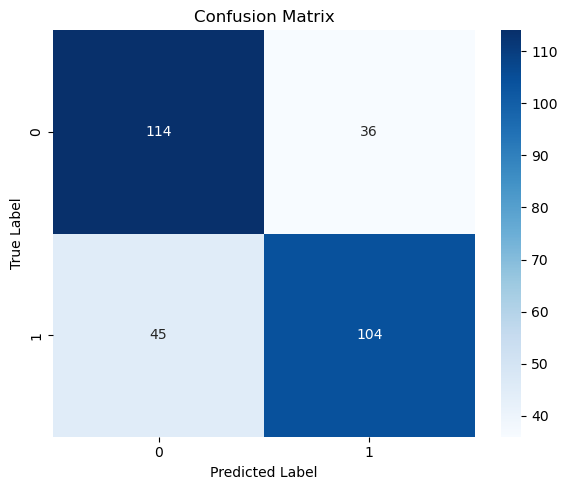

In [19]:
model = UnsimplifiedSemiSupervisedGMM(n_components=optimal_number_of_components, n_classes=2)
model.fit(X_train_mean, y_train_mean, init_method='gmm')
#model.plot_feature_histograms_with_gaussians(X_train_mean)
model.plot_log_likelihood()
model.plot_pca_gaussians(X_train_mean, y_train_mean)
model.plot_tsne_clusters(X_test_mean, y_test_mean)

print("Evaluation for Unsimplified Semi-Supervised GMM")
cluster_preds, cluster_probs, gamma = model.predict_clusters(X_test_mean)
evaluate_cluster_labels(cluster_preds, y_test_mean.ravel())
confusion_matrix_and_metrics(cluster_preds, y_test_mean)

Evaluation for cross cluster hard labels assignation
Confusion Matrix:
[[114  36]
 [ 45 104]]

Accuracy:  0.729
Precision: 0.730
Recall:    0.729
F1 Score:  0.729


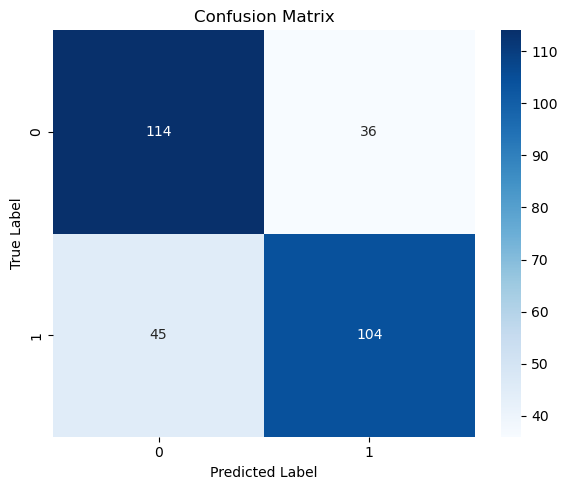

Confident predictions: 220 / 299
Confusion Matrix:
[[90 23]
 [26 81]]

Accuracy:  0.777
Precision: 0.779
Recall:    0.757
F1 Score:  0.768


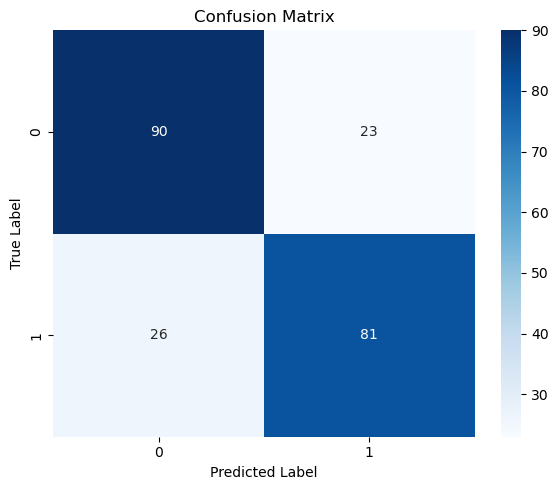

In [27]:
print("Evaluation for cross cluster hard labels assignation")
predicted_labels, class_probs = model.predict_with_cross_cluster_proba(gamma, y_test_mean)
thresholds = {0: 0.8, 1: 0.8}  
filtered_labels = model.predict_with_cross_cluster_proba_with_threshold(predicted_labels, class_probs, thresholds)
confident_mask = final_preds != -1
print(f"Confident predictions: {confident_mask.sum()} / {len(filtered_labels)}")
confusion_matrix_and_metrics(filtered_labels[confident_mask], y_test_mean[confident_mask])